In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
cd /Users/fred/Umila/numila

/Users/fred/Umila/numila


In [3]:
from sklearn import metrics
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('muted')

from main import run


# ROC

In [44]:
roc_df = pd.read_pickle('pickles/dyn_roc')
# roc_df['holo'] = [name.startswith('holo') for name in roc_df.model]
roc_df.head()

,auc,fpr,model,tpr,lang,kind
0,0.691038,"[0.0, 0.00107584722969, 0.00107584722969, 0.00...",holo,"[0.0, 0.026, 0.028, 0.03, 0.03, 0.034, 0.034, ...",English,word
1,0.691260,"[0.0, 0.00107584722969, 0.00107584722969, 0.00...",dynamic1,"[0.0, 0.026, 0.028, 0.03, 0.03, 0.034, 0.034, ...",English,word
2,0.707620,"[0.0, 0.00107584722969, 0.00107584722969, 0.00...",dynamic3,"[0.0, 0.026, 0.028, 0.03, 0.03, 0.034, 0.034, ...",English,word
3,0.692817,"[0.0, 0.00107584722969, 0.00107584722969, 0.00...",dynamic5,"[0.0, 0.026, 0.028, 0.03, 0.03, 0.034, 0.034, ...",English,word
0,0.747842,"[0.0, 0.000942507068803, 0.000942507068803, 0....",holo,"[0.0, 0.018, 0.02, 0.028, 0.044, 0.046, 0.046,...",English,syl


In [45]:
# def parse_name(name):
#     return tuple(map(float, name.split('_')))
    

# roc_df['learn_rate'], roc_df['exemplar'], roc_df['init_row'] = \
#    zip(*[parse_name(name) for name in roc_df.model])



# for kind in 'word', 'syl', 'phone':
#     top = roc_df[roc_df.kind == kind].sort_values('auc', ascending=False)[:3]
#     print('\n', '--', kind)
#     for i, row in top.iterrows():
#         print(row.auc, row.learn_rate, row.exemplar, row.init_row)

# roc_df.groupby('model').auc.mean().sort_values()

In [46]:
def roc_plot(df):
    ax = plt.subplot(1,1,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    for i, row in df.iterrows():
        plt.plot(row.fpr, row.tpr, label='{0} (area = {1:0.2f})'
                 .format(row.model, row['auc']))

    # Sort labels in legend.
    handles, labels = ax.get_legend_handles_labels()
    def get_aoc(handle_label):
        label = handle_label[1]
        return float(label[-5:-1])
    hl = sorted(zip(handles, labels), key=get_aoc, reverse=True)
    handles2, labels2 = zip(*hl)
    ax.legend(handles2, labels2, loc=4, frameon=True)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.gcf().set_size_inches(6, 6)

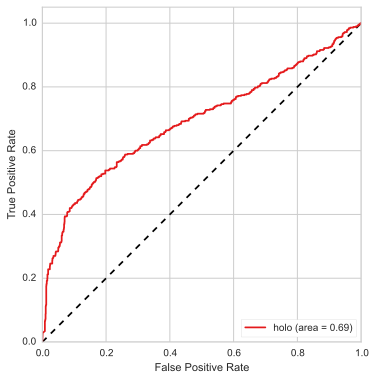

In [47]:
# Plot roc curve for English words.
with sns.color_palette('Set1', 10):
    roc_plot(roc_df.query("lang == 'English' and kind == 'word' and model in ['holo', 'random']"))
    # roc_plot(roc_df)
    plt.savefig('figs/roc-curve.pdf')

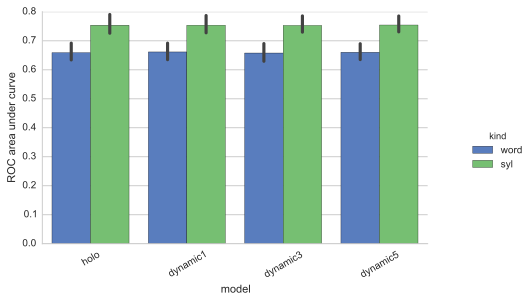

In [48]:
# ROC auc for each model and input type, collapsed across language
sns.factorplot('model', 'auc', hue='kind', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/tp-roc-type.pdf', bbox_inches='tight')

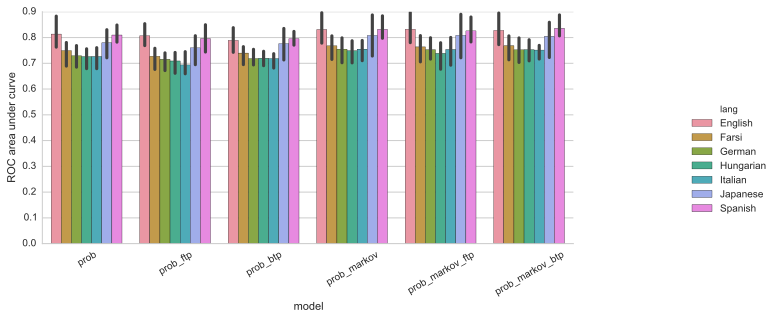

In [41]:
# ROC auc for each model and language, collapsed across input type.
sns.factorplot('model', 'auc', hue='lang', kind='bar', data=roc_df)

plt.xticks(rotation=30)
plt.ylabel('ROC area under curve')
plt.gcf().set_size_inches(12, 4)
plt.savefig('figs/roc-lang.pdf', bbox_inches='tight')

# BLEU

In [5]:
bleu_df = pd.read_pickle('pickles/prob_bleu')

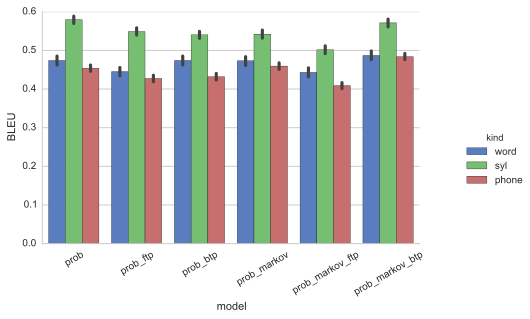

In [15]:
sns.factorplot(x='model', y='BLEU', hue='kind', data=bleu_df, kind='bar',
#             order=['holo', 'compose', 'prob',  'trigram']
               )
# plt.legend().draw_frame(True)
plt.xticks(rotation=30)
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/bleu.pdf', bbox_inches='tight')

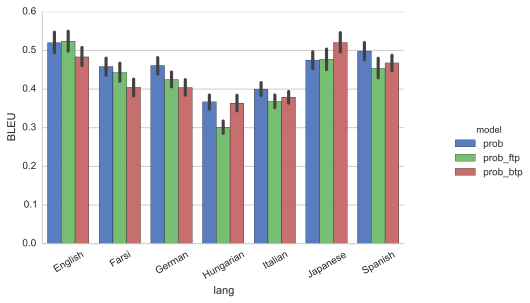

In [30]:
df = bleu_df.query("kind=='phone' and model in ['prob', 'prob_ftp', 'prob_btp'] ")
sns.factorplot(x='lang', y='BLEU', hue='model', data=df, kind='bar')
# plt.legend().draw_frame(True)
plt.xticks(rotation=30)
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/bleu.pdf', bbox_inches='tight')

In [54]:
chunk_df = pd.read_pickle('pickles/dyn_chunk')

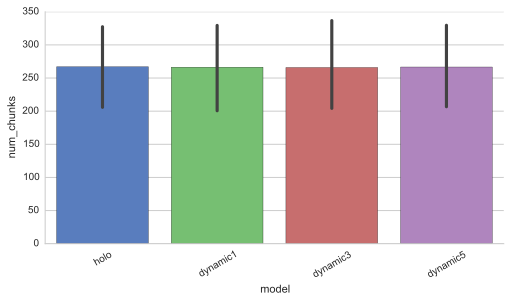

In [57]:
sns.factorplot(x='model', y='num_chunks',  data=chunk_df, kind='bar',
#             order=['holo', 'compose', 'prob',  'trigram']
               )
# plt.legend().draw_frame(True)
plt.xticks(rotation=30)
plt.gcf().set_size_inches(8, 4)
plt.savefig('figs/tp-bleu.pdf', bbox_inches='tight')

In [13]:
# full_df = roc_df[['ROC area under curve', 'model', 'language']].rename(columns={'ROC area under curve': 'measure'}).head()

full_df = pd.concat([pd.melt(roc_df, id_vars=['model', 'language'],
                   value_vars=['ROC area under curve'], var_name='measure'), 
           pd.melt(bleu_df, id_vars=['model', 'language'],
                   value_vars=['BLEU'], var_name='measure')])
    
sns.factorplot('model', 'value', hue='language', col='measure', data=full_df,
                   kind='bar', col_order=['BLEU', 'ROC area under curve'],
                   order=['holo', 'prob', 'trigram', 'random'])
plt.savefig('figs/combined.pdf')

ValueError: min() arg is an empty sequence